### Downloading all important packages required


In [1]:
%pip install --upgrade yfinance 
%pip install matplotlib
%pip install seaborn



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Importing all the required libraries

In [2]:
import yfinance as yf 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Creating the class named Trade where the necessary attributes and methods related to the asset will be stored.


In [3]:

#Trade class begins here....
class Trade:

    # Initialistaion of the trade class it takes the ticker as argument and stores two attributes namely the ticker and the dataframe(including 
    # both adjusted and non adjusted price).

    def __init__(self,ticker):
        self.ticker=ticker
        self.df=yf.download(ticker,start='2013-01-01',end='2022-12-31',auto_adjust=False)

    #This function cleans the data that is it first tries to interpolate if gaps are small and then tries to forward fill if still nan 
    #exist then it is dropped.

    def clean_data(self):
        self.df=self.df.interpolate(method='polynomial',axis=0,limit=5,order=2)
        self.df=self.df.ffill()
        self.df=self.df.dropna()
    
    #This function gives the daily returns of the asset.

    def get_daily_returns(self):
        return self.df['Adj Close'].pct_change().fillna(0)
    
    #Here we created a static function so that it can be used without the object of the class.
    #This function returns the cumulative return of a portfolio's daily returns.

    @staticmethod
    def cumulative_return(portfolio_daily_returns):
        cumulative_ret=1
        for num in portfolio_daily_returns:
            cumulative_ret*=(1+num)
        cumulative_ret-=1
        return cumulative_ret
    
    #This function returns the annualized return of the portfolio although trading days in an year is 252 but since we interpolated and
    #forward filled therefore we are using 365 days in the year.

    @staticmethod
    def annulaized_return(cumulative_ret,days):
        return (1+cumulative_ret)**(365/days)-1
    
    #This function returns the annualized volatility of the portfolio.

    @staticmethod
    def annualized_volatility(portfolio_daily_returns,trading_days=365):
        return portfolio_daily_returns.std()*np.sqrt(trading_days)
    
    #This function calculates the sharpe ratio and risk_free_rate by default we will be using 0.03.

    @staticmethod
    def sharpe_ratio(annualized_return, annualized_volatility, risk_free_rate=0.03):
        return (annualized_return - risk_free_rate) / annualized_volatility
    
    #This function computes the drawdown of the portfolio.

    @staticmethod
    def drawdown(portfolio_daily_returns):
        cumulative=(portfolio_daily_returns+1).cumprod()
        running_max = np.maximum.accumulate(cumulative)
        return (cumulative - running_max) / running_max
    
    #The following function computes the maximum drawdown and the duration of the drawdown as well from the drawdown computed from the above 
    # function.

    @staticmethod
    def max_drawdown(portfolio_daily_returns):
        new_frame=Trade.drawdown(portfolio_daily_returns)
        max_duration=0
        current_duration=0
        for dd in new_frame:
            if dd < 0:
                current_duration += 1
                max_duration = max(max_duration, current_duration)
            else:
                current_duration = 0
        return [np.min(new_frame),max_duration]
    
    #This function returns the adj_close price of the particular asset.

    def adj_close(self):
        return self.df['Adj Close']
    
    #This function creates and returns the correlation matrix.
 
    @staticmethod
    def correlation_matrix(tickers):
        dataframe=pd.DataFrame()
        for ticker in tickers:
            dataframe[ticker]=ticker.adj_close()
        returns = dataframe.pct_change().dropna()
        correlationmatrix = returns.corr()
        return correlationmatrix
    
    #The following function computes the rolling correlation between the assets over a period of 1 year.

    @staticmethod
    def rolling_correlation(returns_df):
        return returns_df.rolling(window=30).corr()
    
    #The following function plots the cumulative return of the portfolio over time.

    @staticmethod
    def plot_cumulative_return(portfolio_daily_returns):
        cumulative_returns = (1 + portfolio_daily_returns).cumprod()
        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_returns, label='Cumulative Return')
        plt.title("Cumulative Return of the Portfolio Over Time")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Return")
        plt.grid(True)
        plt.legend()
        plt.show()
    
    #The following function plots the rolling volatility of the portfolio.

    @staticmethod
    def plot_portfolio_rolling_volatility(portfolio_daily_returns):
        portfolio_rolling_volatility = portfolio_daily_returns.rolling(window=30).std()
        plt.figure(figsize=(10, 6))
        portfolio_rolling_volatility.plot(label='Portfolio Rolling Volatility', color='black')
        plt.title("30-Day Rolling Volatility of Portfolio")
        plt.xlabel("Date")
        plt.ylabel("Volatility (Std Dev)")
        plt.grid(True)
        plt.legend()
        plt.show()

    #The following function plots the rolling volatility of each of the individual asset.

    def individual_asset_rolling_volatility(self,returns_df):
        individual_asset_rolling_volatility = returns_df[self.ticker].rolling(window=30).std()
        plt.figure(figsize=(10, 6))
        individual_asset_rolling_volatility.plot(label='Portfolio Rolling Volatility', color='black')
        plt.title(f"30-Day Rolling Volatility of {self.ticker}")
        plt.xlabel("Date")
        plt.ylabel("Volatility (Std Dev)")
        plt.grid(True)
        plt.legend()
        plt.show()

    #The following function plots the drawdown curve of the portfolio.

    @staticmethod
    def plot_drawdown_curve(portfolio_daily_returns):
        cumulative_returns = (1 + portfolio_daily_returns).cumprod()
        running_max = cumulative_returns.cummax()
        drawdown = (cumulative_returns - running_max) / running_max
        plt.figure(figsize=(10, 6))
        plt.plot(drawdown, color='red', label='Drawdown')
        plt.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3)
        plt.title("Drawdown Curve of the Portfolio")
        plt.xlabel("Date")
        plt.ylabel("Drawdown (as a % of peak)")
        plt.grid(True)
        plt.legend()
        plt.show()
        pass

    # The following function plots the heatmap of the correlation matrix.
    
    @staticmethod
    def correlation_matrix_plot(correlationmatrix,tickers_dict):
        correlationmatrix=correlationmatrix.rename(index=tickers_dict, columns=tickers_dict)
        plt.figure(figsize=(8, 6))
        sns.heatmap(correlationmatrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
        plt.title("Correlation Matrix of Daily Returns")
        plt.show()



### Part A: Data Acquisition 

### Creating a list of 10 different assets (stocks,crypto and ETFs included) over a 10 year period (From 2013 to 2022 both inclusive)

In [4]:
#List of tickers being used here

tickers = [
    "AAPL",    # Apple
    "MSFT",    # Microsoft
    "TSLA",    # Tesla
    "AMZN",    # Amazon
    "SPY",     # S&P 500 ETF
    "QQQ",     # Nasdaq-100 ETF
    "GLD",     # Gold ETF
    "BTC-USD", # Bitcoin
    "ETH-USD", # Ethereum
    "GC=F"     # Gold Futures
]

#List to store objects of the trade class.

list_of_trades=[]

#All dates included including the non tarding days.

full_dates = pd.date_range(start='2013-01-01', end='2022-12-31', freq="D")
#print(full_dates.shape)
for ticker in tickers:
    list_of_trades.append(Trade(ticker))
for trade in list_of_trades:
    print(trade.df)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price        Adj Close       Close        High         Low        Open  \
Ticker            AAPL        AAPL        AAPL        AAPL        AAPL   
Date                                                                     
2013-01-02   16.669010   19.608213   19.821428   19.343929   19.779285   
2013-01-03   16.458611   19.360714   19.631071   19.321428   19.567142   
2013-01-04   16.000162   18.821428   19.236786   18.779642   19.177500   
2013-01-07   15.906051   18.710714   18.903570   18.400000   18.642857   
2013-01-08   15.948855   18.761070   18.996071   18.616072   18.900356   
...                ...         ...         ...         ...         ...   
2022-12-23  130.344482  131.860001  132.419998  129.639999  130.919998   
2022-12-27  128.535522  130.029999  131.410004  128.720001  131.380005   
2022-12-28  124.591377  126.040001  131.029999  125.870003  129.669998   
2022-12-29  128.120361  129.610001  130.479996  127.730003  127.989998   
2022-12-30  128.436661  129.929993  12

### Part B: Data Cleaning and Preparation

### Gaps in data of less than 5 days were interpolated and quadratic interpolation is used.If still Nan values exist then forward filling is done and even still the Nan values exist thenNan values are removed. Only one Nan value will be removed in this case because we start at 1st Jan 2013the day when market was closed and forward filling can't fill it because no previous data and hence it willbe removed.

In [5]:
#All the dates added to the dataframe including the dates which are non trading days.

for trade in list_of_trades:
    trade.df=trade.df.reindex(full_dates)
    #print(trade.df.shape)
    #print(trade.df.isna().sum())

#The dataframe is cleaned here.

for trade in list_of_trades:
    trade.clean_data()
    #print(trade.df.isna().any().any())
for trade in list_of_trades:
    print(trade.df)

Price        Adj Close       Close        High         Low        Open  \
Ticker            AAPL        AAPL        AAPL        AAPL        AAPL   
2013-01-02   16.669010   19.608213   19.821428   19.343929   19.779285   
2013-01-03   16.458611   19.360714   19.631071   19.321428   19.567142   
2013-01-04   16.000162   18.821428   19.236786   18.779642   19.177500   
2013-01-05   15.770340   18.551079   18.963447   18.400898   18.824684   
2013-01-06   15.812050   18.600139   18.860925   18.290727   18.578433   
...                ...         ...         ...         ...         ...   
2022-12-27  128.535522  130.029999  131.410004  128.720001  131.380005   
2022-12-28  124.591377  126.040001  131.029999  125.870003  129.669998   
2022-12-29  128.120361  129.610001  130.479996  127.730003  127.989998   
2022-12-30  128.436661  129.929993  129.949997  127.430000  128.410004   
2022-12-31  128.436661  129.929993  129.949997  127.430000  128.410004   

Price             Volume  
Ticker    

### Part C: Portfolio Construction

### Diversified portfolio is created and here we assign equal weight to each asset and daily portfolio returns is calculated based on these weights and adjusted closing prices. 

In [6]:
#Weights assigned here and here we give equal weights to each of the asset.

weights = np.array([0.1] * len(list_of_trades))
weights /= weights.sum() 
returns_df = pd.DataFrame(index=full_dates)

#Daily return of each of the asset in portfolio is calculated.

for trade in list_of_trades:
    returns_df[trade.ticker] = trade.get_daily_returns()
    returns_df[trade.ticker]=returns_df[trade.ticker].fillna(0)

# Daily return is then weighted according to the weights and then portfolio daily return is calculated.

portfolio_daily_returns = returns_df.dot(weights)
portfolio_daily_returns = pd.DataFrame(portfolio_daily_returns, columns=['daily_portfolio_return'])
portfolio_daily_returns

,daily_portfolio_return
2013-01-01,0.000000
2013-01-02,0.000000
2013-01-03,-0.006611
2013-01-04,-0.007353
2013-01-05,-0.002212
...,...
2022-12-27,-0.011437
2022-12-28,-0.008513
2022-12-29,0.023519
2022-12-30,0.000376


### Part D: Performance Metrics Calculation

In [7]:
#All the performance Metrics are calculated and printed here. 

cumulative_ret=Trade.cumulative_return(portfolio_daily_returns['daily_portfolio_return'])
print("The cumulative return is ")
print(cumulative_ret)
annualized_ret=Trade.annulaized_return(cumulative_ret,full_dates.shape[0])
print("The annualized return is ")
print(annualized_ret)
annualized_volat=Trade.annualized_volatility(portfolio_daily_returns['daily_portfolio_return'])
print("The annulaized volatility is ")
print(annualized_volat)
sharperatio=Trade.sharpe_ratio(annualized_ret,annualized_volat)
print("The sharpe ratio obtained is ")
print(sharperatio)
maxdrawdown=Trade.max_drawdown(portfolio_daily_returns['daily_portfolio_return'])
print("The maximum drawdown is ")
print(maxdrawdown[0])
print("The maximum drawdown duration is ")
print(maxdrawdown[1]," days.")



The cumulative return is 
9.75195153032847
The annualized return is 
0.2679211342071883
The annulaized volatility is 
0.2106129457714908
The sharpe ratio obtained is 
1.129660540740578
The maximum drawdown is 
-0.40824179941469857
The maximum drawdown duration is 
523  days.


### Part E: Correlation and Risk Analysis

In [8]:
tickers_dict = {
    list_of_trades[0]:'Apple',
    list_of_trades[1]:'Microsoft',
    list_of_trades[2]:'Tesla',
    list_of_trades[3]:'Amazon',
    list_of_trades[4]:'S&P 500 ETF',
    list_of_trades[5]:'Nasdaq-100 ETF',
    list_of_trades[6]:'Gold ETF',
    list_of_trades[7]:'Bitcoin',
    list_of_trades[8]:'Ethereum',
    list_of_trades[9]:'Gold Futures'
}

#Correlation matric and rolling correlation is computed here.

correlationmatrix=Trade.correlation_matrix(list_of_trades)
rollingcorrelation=Trade.rolling_correlation(returns_df)
print("Printing the last 15 rows of the rollingcorrelation...")
print(rollingcorrelation.tail(15))

Printing the last 15 rows of the rollingcorrelation...
                        AAPL      MSFT      TSLA      AMZN       SPY  \
2022-12-30 QQQ      0.946566  0.952598  0.229640  0.927026  0.967371   
           GLD      0.378222  0.418854 -0.150987  0.465551  0.398583   
           BTC-USD  0.436757  0.516562 -0.149567  0.406064  0.454850   
           ETH-USD  0.413451  0.455316 -0.098867  0.349536  0.428837   
           GC=F     0.388134  0.417116 -0.054563  0.441526  0.405352   
2022-12-31 AAPL     1.000000  0.870858  0.152400  0.815966  0.931700   
           MSFT     0.870858  1.000000  0.170248  0.899704  0.948227   
           TSLA     0.152400  0.170248  1.000000  0.130905  0.142307   
           AMZN     0.815966  0.899704  0.130905  1.000000  0.913799   
           SPY      0.931700  0.948227  0.142307  0.913799  1.000000   
           QQQ      0.946437  0.954535  0.228341  0.936808  0.968315   
           GLD      0.380234  0.455004 -0.200840  0.539124  0.423551   
         

### Part F: Advanced Data Visualization

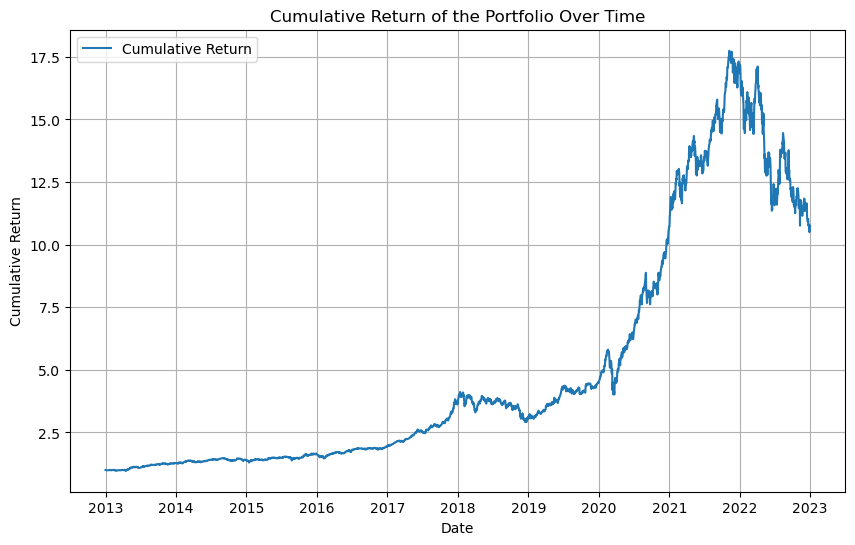

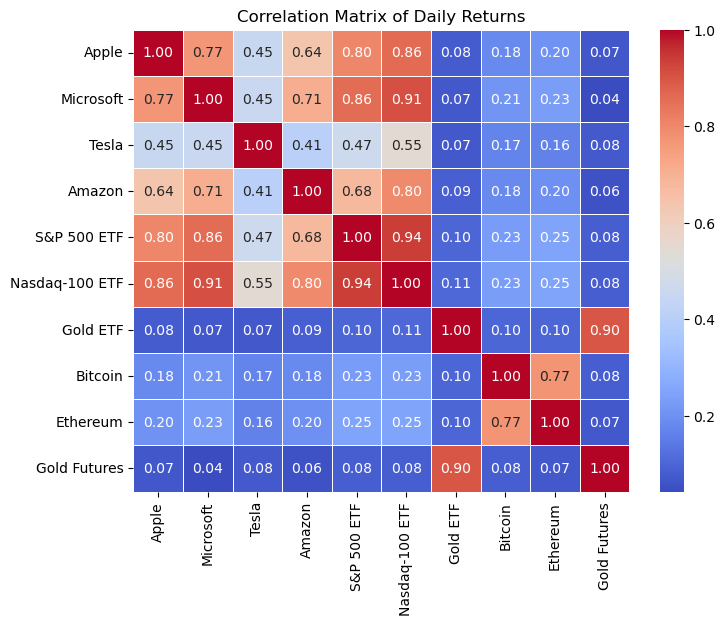

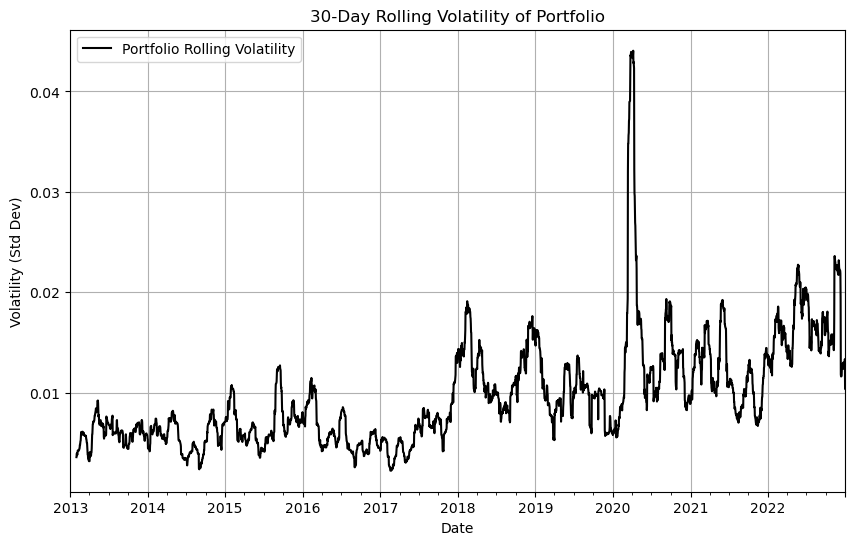

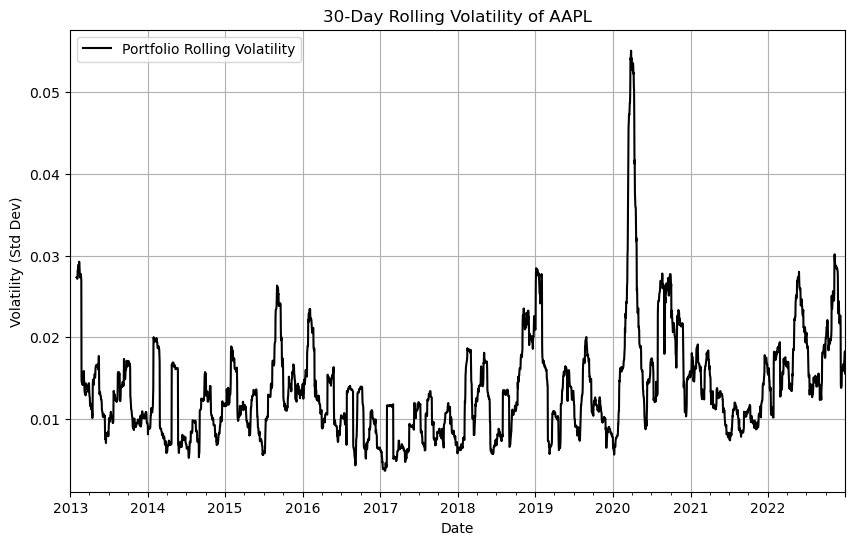

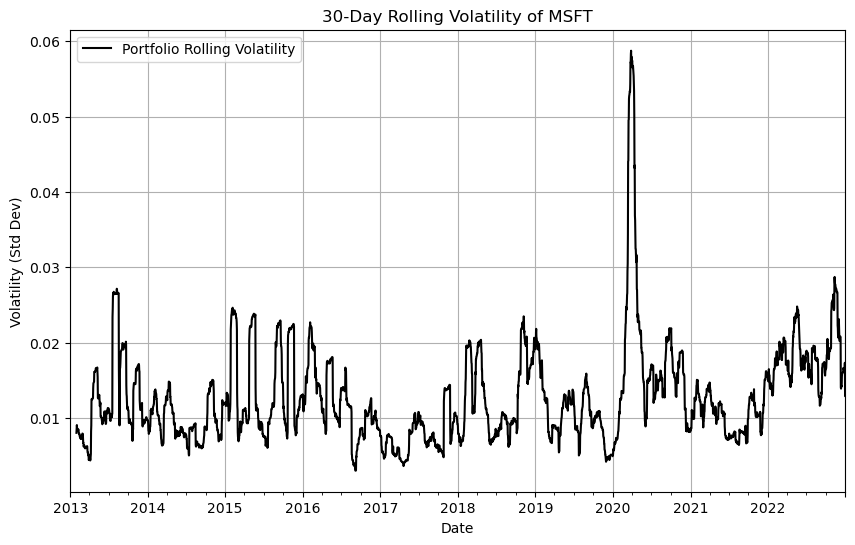

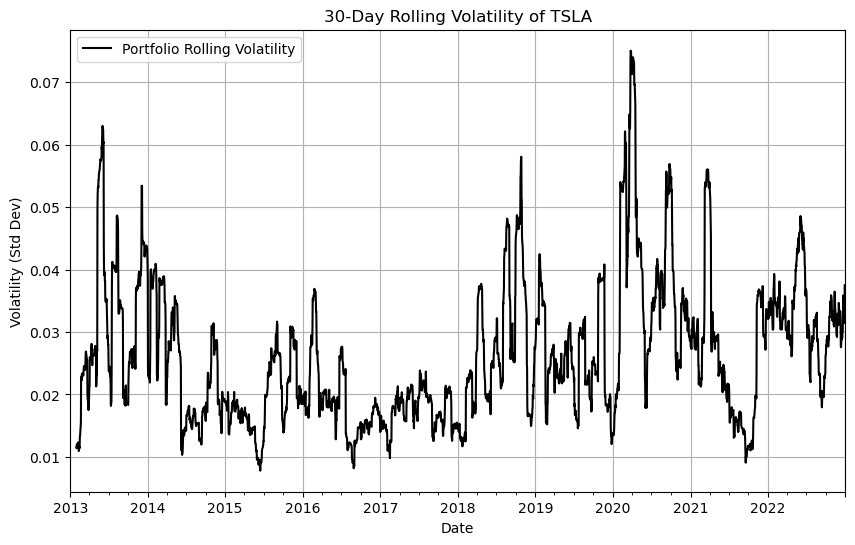

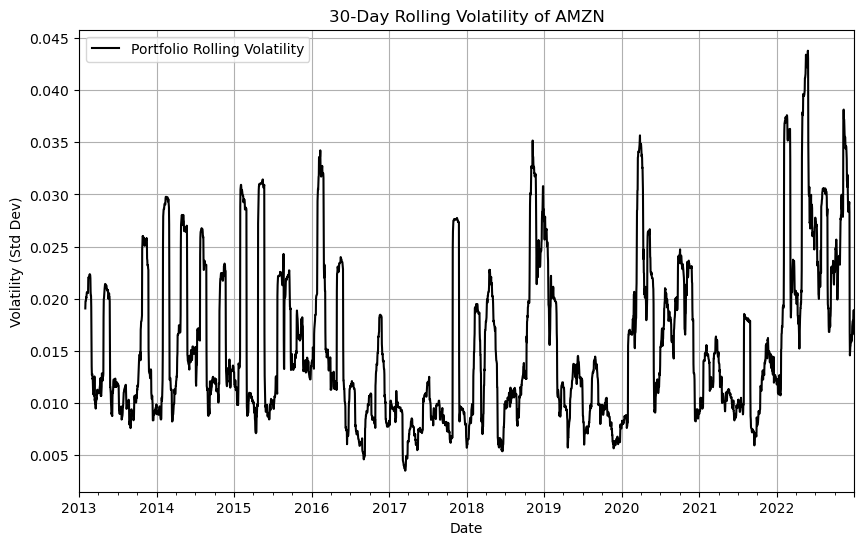

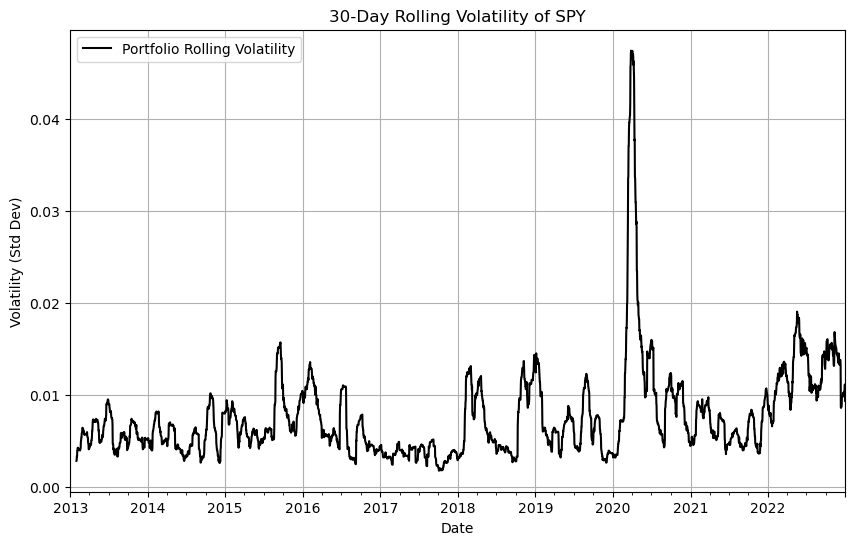

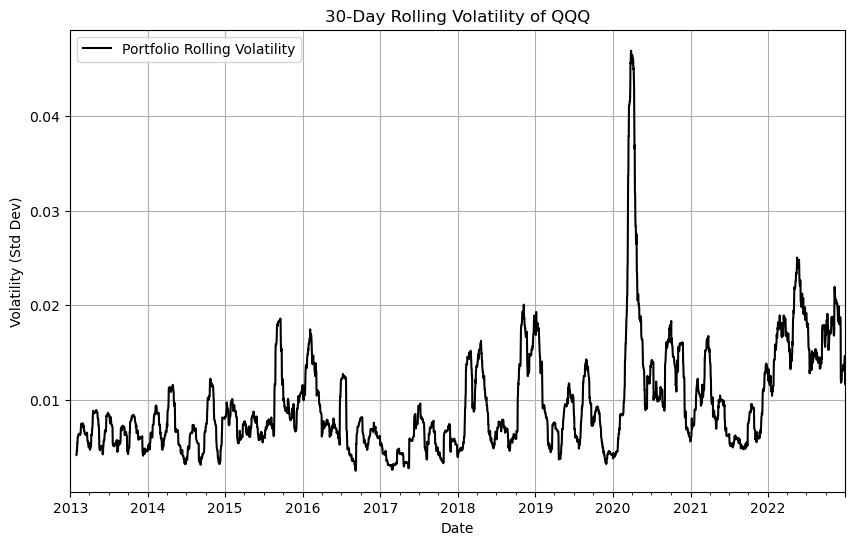

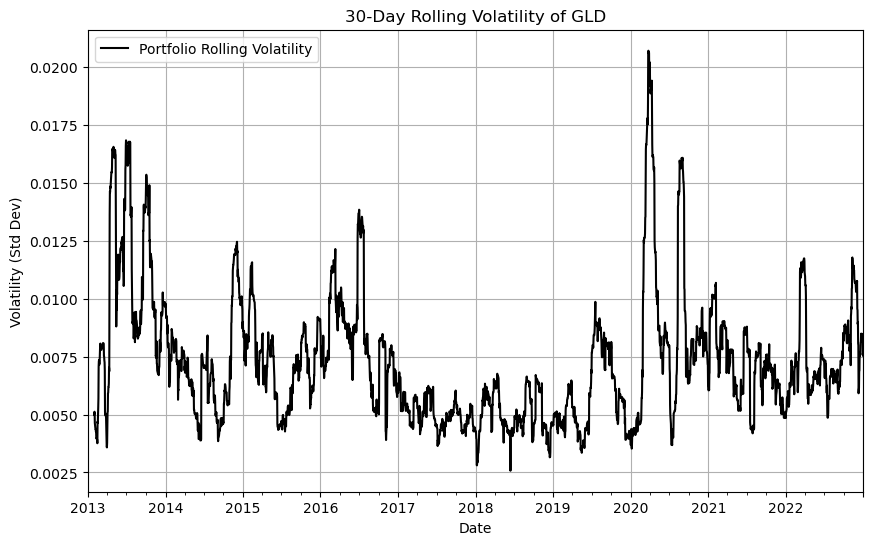

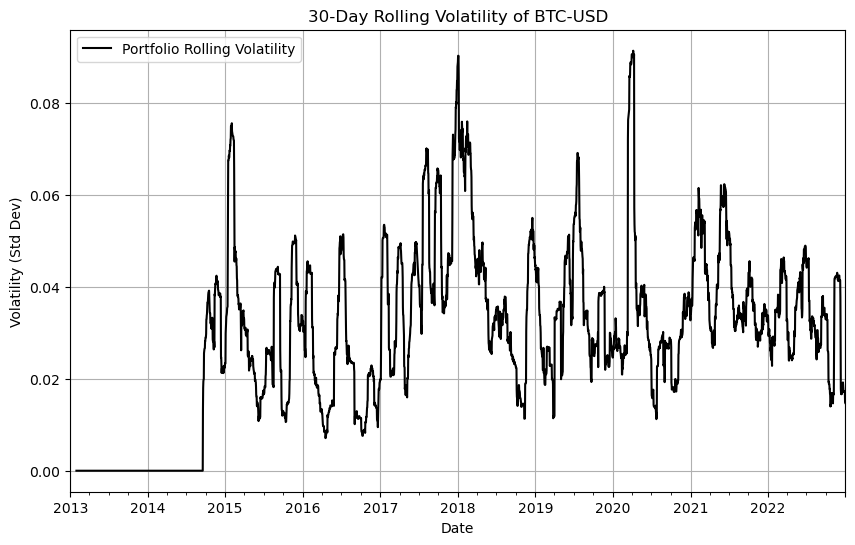

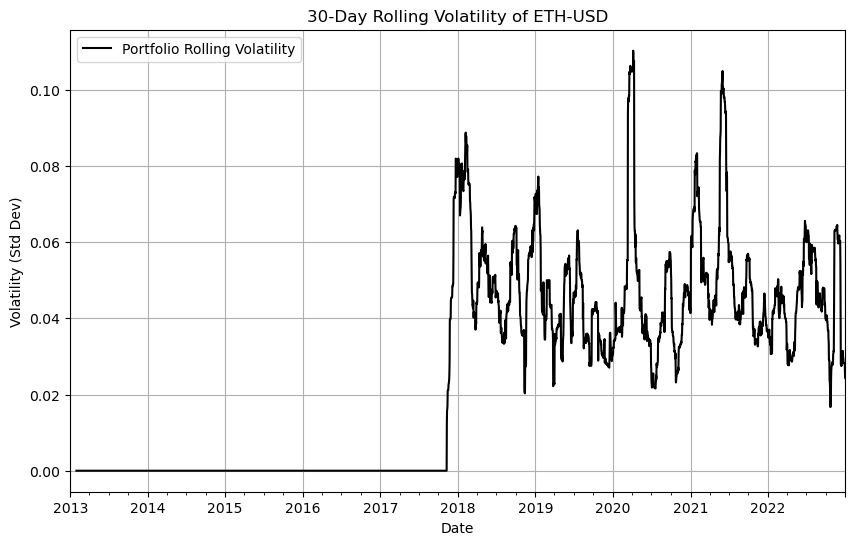

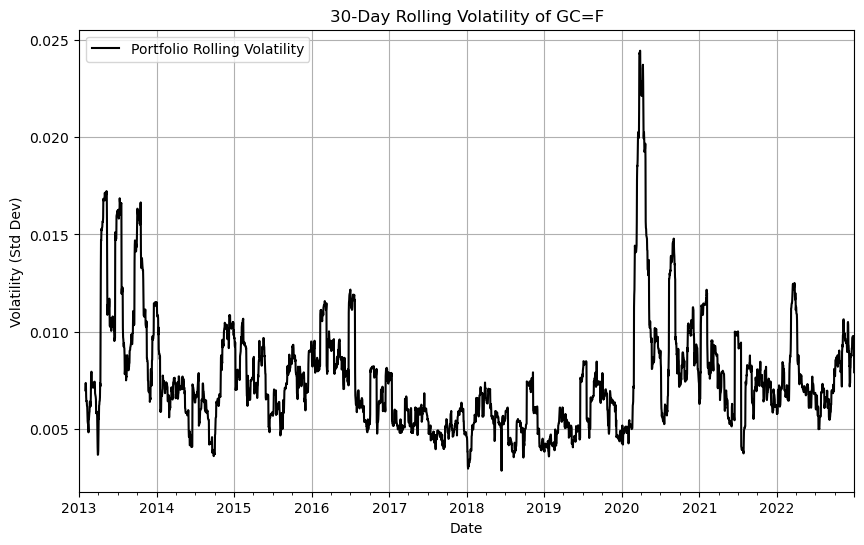

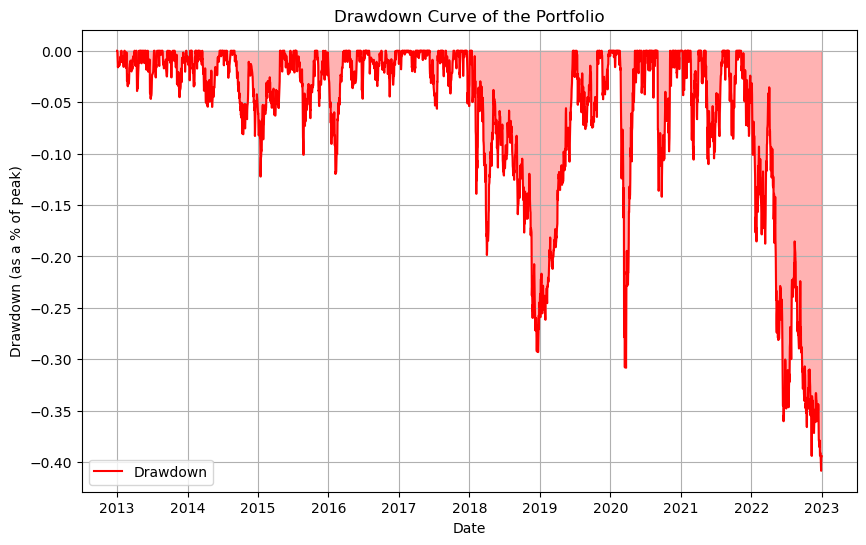

In [9]:
#All the plots are printed here.

Trade.plot_cumulative_return(portfolio_daily_returns['daily_portfolio_return'])
Trade.correlation_matrix_plot(correlationmatrix,tickers_dict)
Trade.plot_portfolio_rolling_volatility(portfolio_daily_returns['daily_portfolio_return'])
for trade in list_of_trades:
    trade.individual_asset_rolling_volatility(returns_df)
Trade.plot_drawdown_curve(portfolio_daily_returns['daily_portfolio_return'])




###                                                 Final Report/Summary

### Introduction

This report presents a detailed analysis of a multi-asset portfolio composed of equities, exchange-traded funds (ETFs), and cryptocurrencies. The aim is to explore the performance, risk characteristics, and inter-relationships among the assets using historical data from 2013 to 2022. Key metrics such as cumulative return, volatility, Sharpe ratio, and drawdowns are computed. The study also includes visual representations such as correlation heatmaps, drawdown curves, and rolling volatility charts to better understand portfolio behavior over time.

### Data Collection 

The source of the data is yahoo finance and to ensure a diversified portfolio, I selected assets across different classes:

Stocks (Equities): AAPL (Apple), MSFT (Microsoft), TSLA (Tesla), AMZN (Amazon)

ETFs (Broad Market Exposure): SPY (S&P 500 ETF), QQQ (Nasdaq-100 ETF)

Commodities (Inflation Hedge): GLD (Gold ETF), GC=F (Gold Futures)

Cryptocurrencies (Alternative Assets): BTC-USD (Bitcoin), ETH-USD (Ethereum)

I included Ethereum (ETH-USD), but since it launched in 2015, its data is only available from August 7, 2015, onward.I proceeded with the full 10-year dataset and let yfinance return NaN for dates before ETH-USD existed. 

### Methodology

Data Cleaning Process:

Interpolation: Minor gaps (e.g., single-day holidays) were filled using linear interpolation.

Forward-Filling: Remaining gaps (e.g., weekends for stocks) were padded with the last available price.

Dropping Residual NaN Values: Rows with unresolvable missing data (e.g., January 1, 2013, a market holiday with no prior data) were excluded.

Portfolio Construction:

Equal Weighting: Each asset was assigned a 10% weight initially.

Daily Returns: Portfolio returns were calculated as the weighted sum of individual asset returns.

Performance Metrics:

The following metrics were computed:

Cumulative Return: Total return over the entire period.

Annualized Return & Volatility: Geometric mean return and standard deviation of daily returns, scaled to a yearly basis.

Sharpe Ratio: Risk-adjusted return relative to a 3% risk-free rate.

Maximum Drawdown: Largest peak-to-trough decline in portfolio value.

Static Correlation Matrix: Pairwise correlations of daily returns to assess diversification benefits.

Rolling Correlations: 30-day rolling correlations to track evolving relationships between assets (e.g., AAPL vs. BTC-USD).

Visualization:

Plots Generated:

Cumulative portfolio returns.

Heatmap of the correlation matrix.

Rolling volatility trends.

Drawdown curve.

### Results and Visualisation

Cumulative Return:-

A cumulative return of 9.75 was obtained using this portfolio which means a 975% return which outperforms the market.

During the same time frame:-(Source Google)
    S&P 500 (~190% over 2013–2023)
    Nasdaq-100 (~380% over the same period)

Our portfolio really outperformed the market.

Outperformance Likely Driven By:-(Source Google)
    Crypto exposure (BTC/ETH had 10,000%+ returns).
    Tech stocks (AAPL: ~1,200%, TSLA: ~15,000%).

In the graph of Cumulative return vs time, a sudden spike is observed around 2020 and it continued till 2022 and then we see a dip in 
the cumulative return. The following reasons explain this change:-

A. COVID-19 Market Dynamics (2020)
    Central banks slashed interest rates and injected liquidity, inflating asset prices.
    Remote work accelerated demand for tech (AAPL, MSFT, AMZN).

B. Cryptocurrency
    BTC peaked at $69,000 in November 2021 (up 1,200% from pre-COVID levels).(Source Google)

And then we see a dip as well after 2022 which caan be explained as follows:-
    Aggressive tightening (interest rates ↑ from 0.25% to 4.5% in 2022) crushed growth assets.(Source Google)
    Less confidence in crypto markets, triggering selloffs.

The portfolio is made up of a mix of assets including technology companies (Apple, Microsoft, Tesla, Amazon), market index funds (S&P 500 ETF and Nasdaq-100 ETF), commodities (Gold ETF and Gold Futures), and cryptocurrencies (Bitcoin and Ethereum). Over the period studied, the portfolio had an annualized return of 26%, which means it earned about 26% per year on average. The annualized volatility was 21%, showing that the portfolio had some ups and downs but stayed within a reasonable risk range.

The Sharpe ratio of 1.12 tells us that the portfolio gave good returns for the amount of risk taken. A Sharpe ratio above 1 is generally considered strong, meaning the portfolio was well-balanced between risk and reward. A big reason for the high returns was the strong performance of Tesla, which saw major growth in recent years. Additionally, Bitcoin and Ethereum contributed significantly, especially during the crypto market boom between 2020 and 2022, before prices dropped in late 2022. These assets helped boost the portfolio's overall performance.

Sharpe Ratio:(Source Google)

< 1.0 – Suboptimal: The return is not high enough for the level of risk taken. May not be worth the risk.

1.0 – 1.99 – Good: The portfolio is earning decent returns for the risk. Considered acceptable in most cases.

2.0 – 2.99 – Very Good: Strong risk-adjusted performance. Shows efficient use of risk.

≥ 3.0 – Excellent: Exceptional performance with very high returns compared to the risk.

The drawdown curve of the portfolio shows how much the portfolio fell from its highest point (peak) over time. The maximum drawdown observed was -40%, which means at its worst, the portfolio lost 40% of its value from its peak. This is a significant drop, and it shows the potential downside risk during unfavorable market conditions.

The duration of the maximum drawdown was 523 days, meaning it took about 1.5 years for the portfolio to recover from that loss and return to its previous peak. This shows that although the portfolio gave high returns over the long term, it was also exposed to periods of deep and extended losses.

From the drawdown curve, we can see that large drawdowns happened mainly during:(Source Google)
    2018–2019, due to market corrections,
    Early 2020, likely caused by the COVID-19 crash,
    2022–2023, which aligns with the decline in tech stocks and cryptocurrencies after the 2021 bull run.

Correlation Analysis
The correlation matrix of daily returns shows that tech companies and major stock indices are highly correlated with each other. For example, Apple, Microsoft, Amazon, Tesla, S&P 500 ETF, and Nasdaq-100 ETF all show strong positive correlations (mostly above 0.7 to 0.9), indicating that they tend to move in the same direction. This is expected, as these tech giants are major components of the stock indices and have shown steady and related growth patterns over the years.

On the other hand, cryptocurrencies (Bitcoin and Ethereum) are also highly correlated with each other (correlation of 0.77), but they have low correlation with both tech stocks and other traditional assets. This reflects how the crypto market has its own unique behavior, driven by different factors compared to traditional equities. The rise of cryptocurrencies, especially during the 2020–2022 boom, created a separate asset class that doesn't always follow stock market movements.

Gold ETF and Gold Futures are also highly correlated (correlation of 0.90), as expected, since both track the price of gold. However, they show very low correlation with tech stocks and crypto, making them useful for diversification.

Rolling correlation helps us understand how the relationship between assets changes over time instead of just giving a single static value. In this analysis, we examined the rolling correlation between selected asset pairs using a fixed time window.(Here 30 days)

Rolling Volatility: Portfolio vs. Individual Assets

Rolling volatility measures how much an asset's or portfolio's returns fluctuate over a sliding time window here 30 days.

Higher Rolling Volatility = More risk (sharp price swings).
Lower Rolling Volatility = Stability (steady returns).

The overall portfolio graph shows fewer ups and downs compared to the individual assets, which is because the portfolio is diversified. This means the risk is spread out, making the returns more stable. On the other hand, when we look at the rolling volatility of individual assets, we see much more fluctuation, especially in commodities and cryptocurrencies, which are more risky. The tech sector also has a lot of fluctuations, though not as much as commodities and crypto.

ETFs (Exchange Traded Funds) have a graph similar to the overall portfolio because they are also diversified, reducing risk in a similar way. In all these graphs, we notice a big spike around 2020. This happened because central banks lowered interest rates and added extra money to the economy, which made asset prices go up. The rise in remote work also increased the demand for tech companies like Apple, Microsoft, and Amazon.

In short, while individual assets like commodities and crypto are more volatile, spreading investments across a portfolio or ETFs can reduce risk and make returns smoother.